In [64]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import os
import pywt
import seaborn as sns
import joblib
import json
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

%matplotlib inline

In [2]:
path_to_cropped = "./dataset/cropped/"
data = {}
for folder in os.scandir(path_to_cropped):
    name = folder.path.split('/')[3]
    data[name] = []
    
    for image in os.scandir(folder.path + '/'):
        data[name].append(image.path)

name_labels = {}
count = 0

for name in data.keys():
    name_labels[name] = count
    count += 1


In [3]:
def transform(img, mode='haar', level=1):
    imArray = img
    imArray = cv2.cvtColor(imArray,cv2.COLOR_RGB2GRAY)
    imArray =  np.float32(imArray)   
    imArray /= 255;
    coeffs=pywt.wavedec2(imArray, mode, level=level)
    coeffs_H=list(coeffs)  
    coeffs_H[0] *= 0;  
    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H = np.uint8(imArray_H)
    return imArray_H

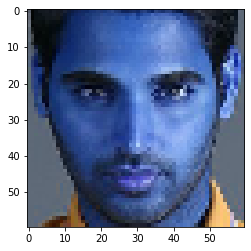

In [4]:
image = cv2.imread("./dataset/cropped/Bhuvneshwar Kumar/Bhuvneshwar Kumar_1.png")
plt.imshow(cv2.resize(image, (60, 60)))

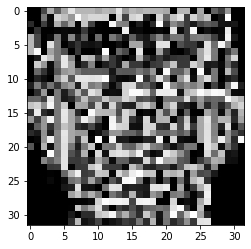

In [26]:
image_transform = transform(image)
plt.imshow(cv2.resize(image_transform, (32, 32)), cmap='gray')

In [65]:
name_labels

{'Bhuvneshwar Kumar': 0,
 'Dinesh Karthik': 1,
 'Hardik Pandya': 2,
 'K L Rahul': 3,
 'Kedar Jadhav': 4,
 'M S Dhoni': 5,
 'Rohit Sharma': 6,
 'Shikhar Dhawan': 7,
 'Virat Kohli': 8,
 'Yuzvendra Chahal': 9}

In [27]:
X = []
Y = []
RESIZE_SIZE = 48

for name in data.keys():
    for image_path in data[name]:
        image = cv2.imread(image_path)
        scaled_image = cv2.resize(image, (RESIZE_SIZE, RESIZE_SIZE))
        wavelet_image = transform(image, 'db1', 5)
        scaled_wavelet_image = cv2.resize(wavelet_image, (RESIZE_SIZE, RESIZE_SIZE))
        combined_image = np.vstack((scaled_image.reshape(RESIZE_SIZE*RESIZE_SIZE*3, 1), scaled_wavelet_image.reshape(RESIZE_SIZE*RESIZE_SIZE, 1)))
        X.append(combined_image)
        Y.append(name_labels[name])

X = np.array(X).reshape(len(X), X[0].shape[0]).astype(float)
Y = np.array(Y)

In [61]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=0)
pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel='rbf', C=10))])

In [63]:
pipe.fit(X_train, Y_train)
print("Score:", pipe.score(X_test, Y_test))
report = classification_report(Y_test, pipe.predict(X_test), output_dict=True)
pd.DataFrame(report)

Score: 0.6440677966101694


,0,1,2,3,4,5,6,7,8,9,accuracy,macro avg,weighted avg
precision,0.666667,1.000000,0.545455,0.647059,1.000000,0.571429,1.00,0.687500,0.666667,1.000000,0.644068,0.778478,0.726054
recall,0.444444,0.444444,0.960000,0.785714,0.375000,0.571429,0.25,0.733333,0.750000,0.142857,0.644068,0.545722,0.644068
f1-score,0.533333,0.615385,0.695652,0.709677,0.545455,0.571429,0.40,0.709677,0.705882,0.250000,0.644068,0.573649,0.617951
support,9.000000,9.000000,25.000000,14.000000,8.000000,7.000000,8.00,15.000000,16.000000,7.000000,0.644068,118.000000,118.000000


In [30]:
models = {
    'svm': {
        'model': SVC(gamma='auto',probability=True),
        'params' : {
            'svc__C': [1, 5, 10],
            'svc__kernel': ['rbf', 'linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [1, 5, 10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'logisticregression__C': [1, 5, 10]
        }
    }
}

In [42]:
scores = []
best_estimators = {}

for name, config in models.items():
    print(name)
    pipe = make_pipeline(StandardScaler(), config['model'])
    classifier = GridSearchCV(pipe, config['params'], cv=5, return_train_score=False)
    classifier.fit(X_train, Y_train)
    scores.append({
        'model' : name,
        'score' : classifier.best_score_,
        'params': classifier.best_params_
    })
    best_estimators[name] = classifier.best_estimator_

result = pd.DataFrame(scores, columns=['model', 'score', 'params'])

svm
random_forest
logistic_regression


In [43]:
result

,model,score,params
0,svm,0.666720,"{'svc__C': 1, 'svc__kernel': 'linear'}"
1,random_forest,0.375694,{'randomforestclassifier__n_estimators': 10}
2,logistic_regression,0.669457,{'logisticregression__C': 1}


In [44]:
best_estimators['svm'].score(X_test, Y_test)

0.7542372881355932

In [45]:
best_estimators['logistic_regression'].score(X_test, Y_test)

0.7966101694915254

In [46]:
best_estimators['random_forest'].score(X_test, Y_test)

0.4491525423728814

<AxesSubplot:>

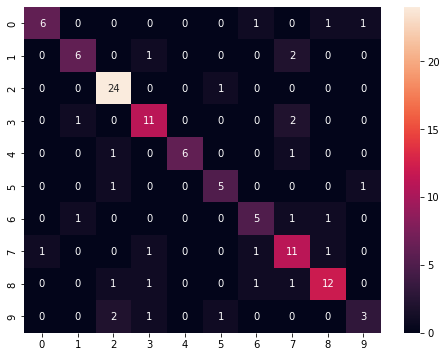

In [56]:
model = best_estimators['svm']

matrix = confusion_matrix(Y_test, model.predict(X_test))
plt.figure(figsize=(8,6))
plt.xlabel("PREDICTED")
plt.ylabel("TRUTH")
sns.heatmap(matrix, annot=True)

In [59]:
joblib.dump(model, "model.pkl")

['model.pkl']

In [68]:
with open("classes.json", "w") as f:
    f.write(json.dumps(name_labels))